### Original data.zip checker

Checks the contents of the data folder

In [8]:
import os, tqdm, json, numpy as np
from matplotlib import pyplot as plt

path = "../data"
max_peaks = 150
out= "new_specs_05_02_22"

Remove Hidden Files

In [3]:
def filter2(data_dir):
    out = []
    for f in os.listdir(data_dir):
        fpath = os.path.join(data_dir, f)
        if f.startswith("."):
            out.append(fpath)
            continue
        for g in os.listdir(fpath):
            gpath = os.path.join(fpath, g)
            if not os.path.isdir(gpath) or g.startswith("."):
                out.append(gpath)
                continue
            for h in os.listdir(gpath):
                if h.startswith("."):
                    out.append(os.path.join(gpath, h))
    return out

out = filter2(path)
print(out)
subdir = ["train", "val"]

for sub in subdir:
    dirs = os.path.join(path, sub)
    for subsub in os.listdir(dirs):
        subsubdir = os.path.join(dirs, subsub)
        print(f"{sub}/{subsub} = {len(os.listdir(subsubdir))}")

[]
train/class = 11810
train/fingerprint = 11810
train/HSQC_2ch = 11810
train/mass_spec_scaled = 11810
train/molecule_weight_s = 11810
train/smiles = 11810
val/class = 1312
val/fingerprint = 1312
val/HSQC_2ch = 1312
val/mass_spec_scaled = 1312
val/molecule_weight_s = 1312
val/smiles = 1312


In [4]:
# load ALL_GNPS
with open("../GNPS/ALL_GNPS.json") as f:
    all_gnps = json.load(f)
del_list = []
for i in tqdm.tqdm(range(len(all_gnps))):
    if all_gnps[i]["peaks_json"] == "[]":
        del_list.append(i)
print("Data Len: ", len(all_gnps))
for i in reversed(del_list):
    del all_gnps[i]
print("Data Len after: ", len(all_gnps))


100%|██████████| 210569/210569 [00:00<00:00, 1138227.30it/s]

Data Len:  210569
Data Len after:  209654


In [9]:
ms_dir = os.path.join(path, "train/mass_spec_scaled")
ms_dir_va = os.path.join(path, "val/mass_spec_scaled")
ccms_train = set([v[:-4] for v in os.listdir(ms_dir)])
ccms_va = set([v[:-4] for v in os.listdir(ms_dir_va)])
print(f"Number of samples: tr[{len(ccms_train)}], va[{len(ccms_va)}]")


Number of samples: tr[11810], va[1312]


In [9]:
print(all_gnps[0].keys())

dict_keys(['spectrum_id', 'source_file', 'task', 'scan', 'ms_level', 'library_membership', 'spectrum_status', 'peaks_json', 'splash', 'submit_user', 'Compound_Name', 'Ion_Source', 'Compound_Source', 'Instrument', 'PI', 'Data_Collector', 'Adduct', 'Scan', 'Precursor_MZ', 'ExactMass', 'Charge', 'CAS_Number', 'Pubmed_ID', 'Smiles', 'INCHI', 'INCHI_AUX', 'Library_Class', 'SpectrumID', 'Ion_Mode', 'create_time', 'task_id', 'user_id', 'InChIKey_smiles', 'InChIKey_inchi', 'Formula_smiles', 'Formula_inchi', 'url', 'annotation_history'])


In [6]:
def process(peaks):
    m = max(peaks, key=lambda p: p[1])
    peaks = np.array([[x, (y/m[1])**0.5] for x, y in peaks])
    if len(peaks) > max_peaks:
        # only preserve max_peaks highest peaks
        inds = np.argpartition(peaks[:, 1], -max_peaks)
        peaks = peaks[inds][-max_peaks:]
    return peaks

os.makedirs(os.path.join(out, "train"), exist_ok=True)
os.makedirs(os.path.join(out, "val"), exist_ok=True)
for sample in tqdm.tqdm(all_gnps):
    spec_id = sample["spectrum_id"]
    if spec_id in ccms_train:
        arr = np.array(json.loads(sample["peaks_json"]))
        arr = process(arr)
        np.save(os.path.join(out, "train", spec_id), arr)
    if spec_id in ccms_va:
        arr = np.array(json.loads(sample["peaks_json"]))
        arr = process(arr) 
        np.save(os.path.join(out, "val", spec_id), arr)

100%|██████████| 209654/209654 [01:35<00:00, 2194.69it/s]  


In [10]:
new_dir = os.path.join(out, "train")
new_dir_va = os.path.join(out, "val")
assert(set(os.listdir(ms_dir)) == set(os.listdir(new_dir)))
assert(set(os.listdir(ms_dir_va)) == set(os.listdir(new_dir_va)))

### Verifying Format

In [3]:
def plot(specs, title=""):
    '''
    Plots a spec
    '''
    f = plt.figure(figsize=(25, 15))
    if len(title) > 0: f.suptitle(title)

    ax = f.add_subplot(1, 1, 1)
    ax.plot(specs)
    ax.set_title(title)
    ax.set(xlabel='m/z', ylabel='intensity')
    f.show()

In [4]:
data_dir_1 = "../data/train/fingerprint"

for f in os.listdir(data_dir_1):
    arr = np.load(os.path.join(data_dir_1, f))
    print(arr.shape, arr)
    break


(6144,) [0 0 0 ... 0 0 0]


In [23]:
data_dir_2 = "../data/train/mass_spec_scaled"
data_dir_2b = "../data/val/mass_spec_scaled"
for f in os.listdir(data_dir_2):
    arr = np.load(os.path.join(data_dir_2, f))
    mi= np.min(arr)
    arr = arr - mi
    if 0.0 == np.max(arr):
        print("train", f, mi, np.max(arr))
    else:
        arr = arr / np.max(arr)
    np.save(os.path.join(data_dir_2, f), arr)
    

for f in os.listdir(data_dir_2b):
    arr = np.load(os.path.join(data_dir_2b, f))
    mi= np.min(arr)
    arr = arr - mi
    if 0.0 == np.max(arr):
        print("val", f, mi, np.max(arr))
    else:
        arr = arr / np.max(arr)
    np.save(os.path.join(data_dir_2b, f), arr)

train CCMSLIB00000418018.npy 10.0 0.0
train CCMSLIB00000424718.npy 10.0 0.0
train CCMSLIB00000478652.npy 10.0 0.0
train CCMSLIB00000579203.npy 10.0 0.0
train CCMSLIB00000579204.npy 10.0 0.0
train CCMSLIB00000579208.npy 10.0 0.0
train CCMSLIB00000579210.npy 10.0 0.0
train CCMSLIB00000579213.npy 10.0 0.0
train CCMSLIB00000579215.npy 10.0 0.0
train CCMSLIB00000579286.npy 10.0 0.0
train CCMSLIB00000839963.npy 10.0 0.0
train CCMSLIB00000840557.npy 10.0 0.0
train CCMSLIB00000840558.npy 10.0 0.0
train CCMSLIB00001055095.npy 10.0 0.0
train CCMSLIB00001055097.npy 10.0 0.0
train CCMSLIB00001058205.npy 10.0 0.0
train CCMSLIB00001058209.npy 10.0 0.0
train CCMSLIB00001058211.npy 10.0 0.0
train CCMSLIB00001058220.npy 10.0 0.0
train CCMSLIB00001058223.npy 10.0 0.0
train CCMSLIB00001058225.npy 10.0 0.0
train CCMSLIB00001058227.npy 10.0 0.0
train CCMSLIB00001058229.npy 10.0 0.0
train CCMSLIB00001058231.npy 10.0 0.0
train CCMSLIB00001058234.npy 10.0 0.0
train CCMSLIB00001058236.npy 10.0 0.0
train CCMSLI

C:\Users\James\anaconda3\envs\smart\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


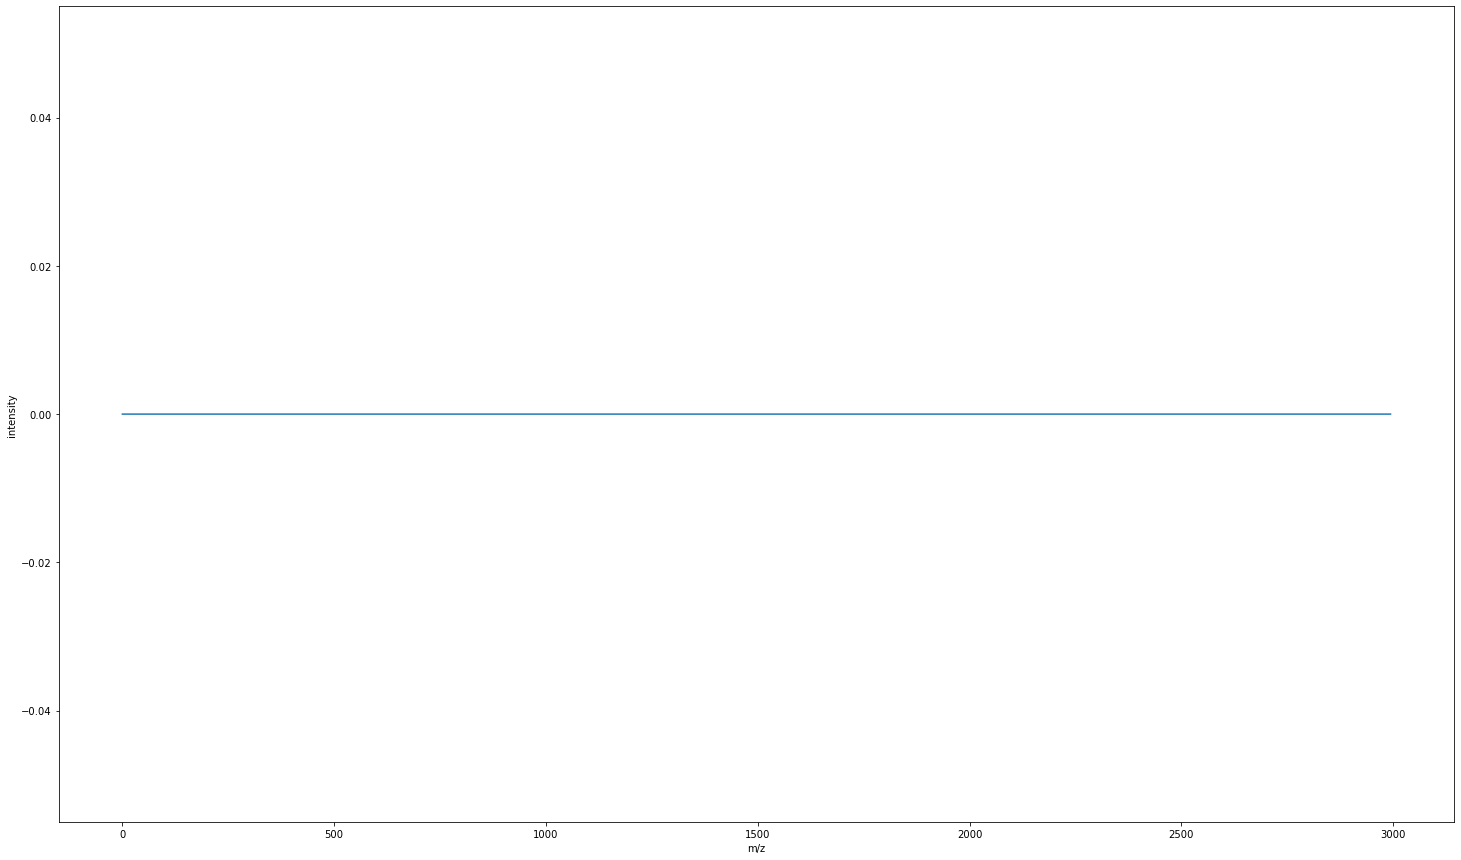

In [24]:
plot(np.load("../data/train/mass_spec_scaled/CCMSLIB00000579203.npy"))

In [11]:
cmm_to_peaks = {}
for v in all_gnps:
    cmm_to_peaks[v["spectrum_id"]] = v["peaks_json"]
    

16337.411133


C:\Users\James\anaconda3\envs\smart\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


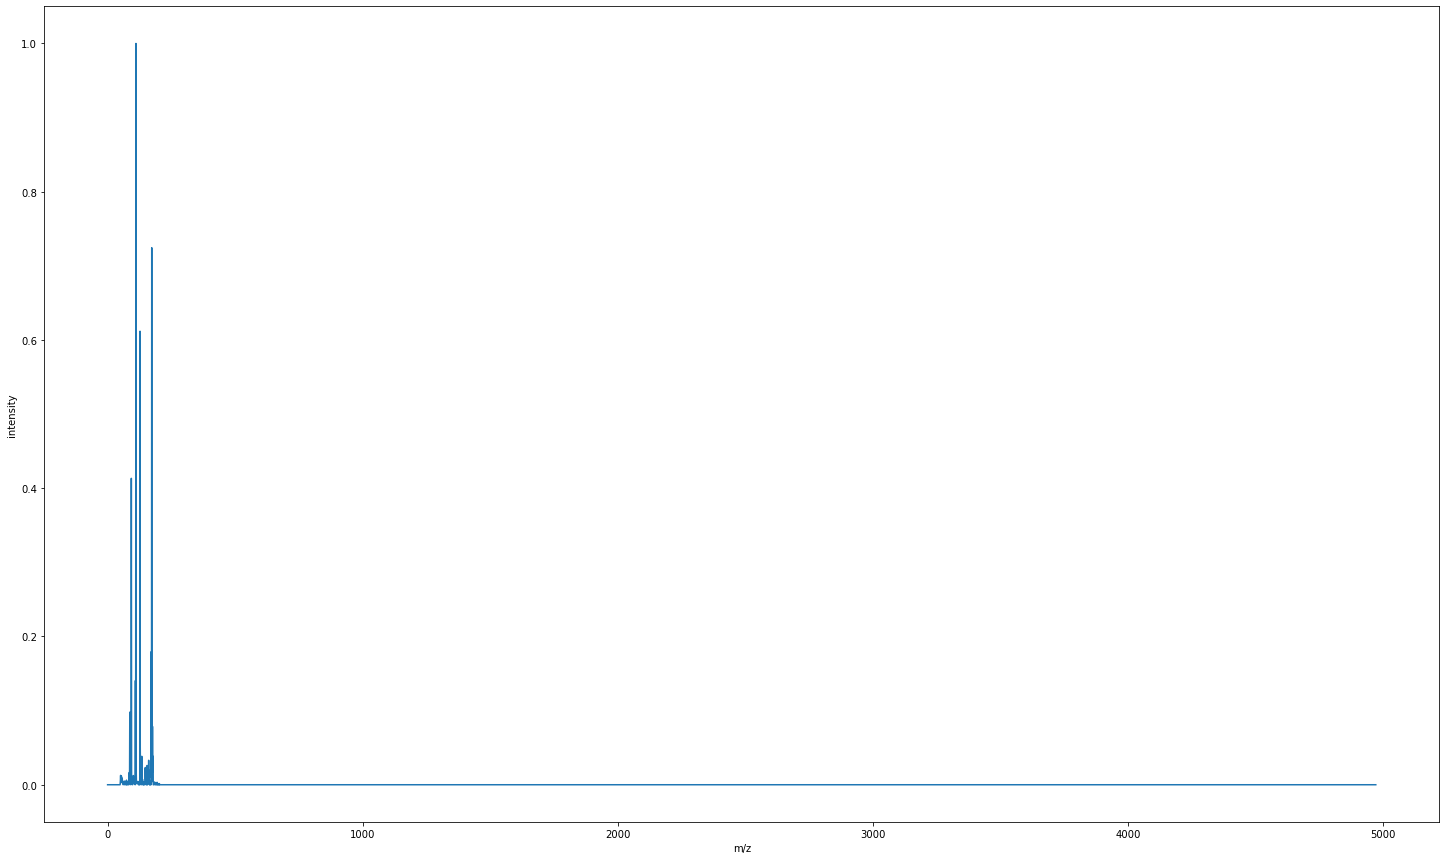

In [22]:
# investingating zero-entries
def bin_spectra(spectra):
    res = [0 for i in range(4973)]
    x, y = zip(*spectra)
    for i in range(len(x)):
        res[int(x[i] + 0.5)] += y[i]
    max_value = max(res)
    for i in range(len(res)):
        res[i] /= max_value
    return res
spectra = eval(cmm_to_peaks["CCMSLIB00000579203"])
print(np.max(spectra))
plot(bin_spectra(eval(cmm_to_peaks["CCMSLIB00000579203"])))